Required libraries for K-Nearest Neighbours (KNN)

- pandas
- scikit-learn
- matplotlib
- seaborn

> Ensure required libraries are installed before running the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.inspection import permutation_importance

Load the dataset to be used

In [2]:
# Load dataset
train_df = pd.read_csv('train_data_with_traffic_class.csv')
test_df = pd.read_csv('test_data_with_traffic_class.csv')

Drop the irrelevant columns from the dataset to be used as features and use one-hot encoding to convert catogrical variables to binary format for machine learning model.

Scaling of features to ensure standardise data for data processing.

In [3]:
# Define features (X) and target (y) for training dataset
X_train_features = train_df.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])
# Encode categorical variables with One-hot encoding
X_train_features = pd.get_dummies(X_train_features, columns=["Country"], drop_first=True)
y_train_labels = train_df["Traffic_Class"]

# Define features (X) and target (y) for test dataset
X_test_features = test_df.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])
# Encode categorical variables with One-hot encoding
X_test_features = pd.get_dummies(X_test_features, columns=["Country"], drop_first=True)
y_test_labels = test_df["Traffic_Class"]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train_labels, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_features)

Initialize the KNN model with default parameters, then train and validate with training data. After validating with training data, validate the model performance with test data to check both the accuracy and balanced accuracy.

Generate a classification report with precision, recall, f1-score and support.

In [4]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model on the training data
knn.fit(X_train_scaled, y_train)

# Validate the model on the validation set
y_val_pred = knn.predict(X_val_scaled)

# Evaluate model performance on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Balanced Accuracy: {balanced_acc:.4f}")

unique_classes = np.unique(y_val)
# Convert to string if necessary
target_names = [str(cls) for cls in unique_classes]

# Display classification report with precision, recall, f1-score, and support
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Validate the model on the test set
y_test_pred = knn.predict(X_test_scaled)

# Evaluate model performance on the test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

# Display classification report for the test set
print("\nTest Classification Report:")
print(classification_report(y_test_labels, y_test_pred, target_names=target_names))


Validation Accuracy: 0.9060
Validation Balanced Accuracy: 0.8588

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1130
           1       0.65      0.79      0.71        53
           2       0.76      0.86      0.81       307

    accuracy                           0.91      1490
   macro avg       0.79      0.86      0.82      1490
weighted avg       0.91      0.91      0.91      1490

Test Accuracy: 0.7684
Test Balanced Accuracy: 0.6872

Test Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       229
           1       0.88      0.53      0.67        43
           2       0.99      0.53      0.69       177

    accuracy                           0.77       449
   macro avg       0.86      0.69      0.73       449
weighted avg       0.83      0.77      0.75       449



Generate a confusion matrix to visualise the accuracy of classication.

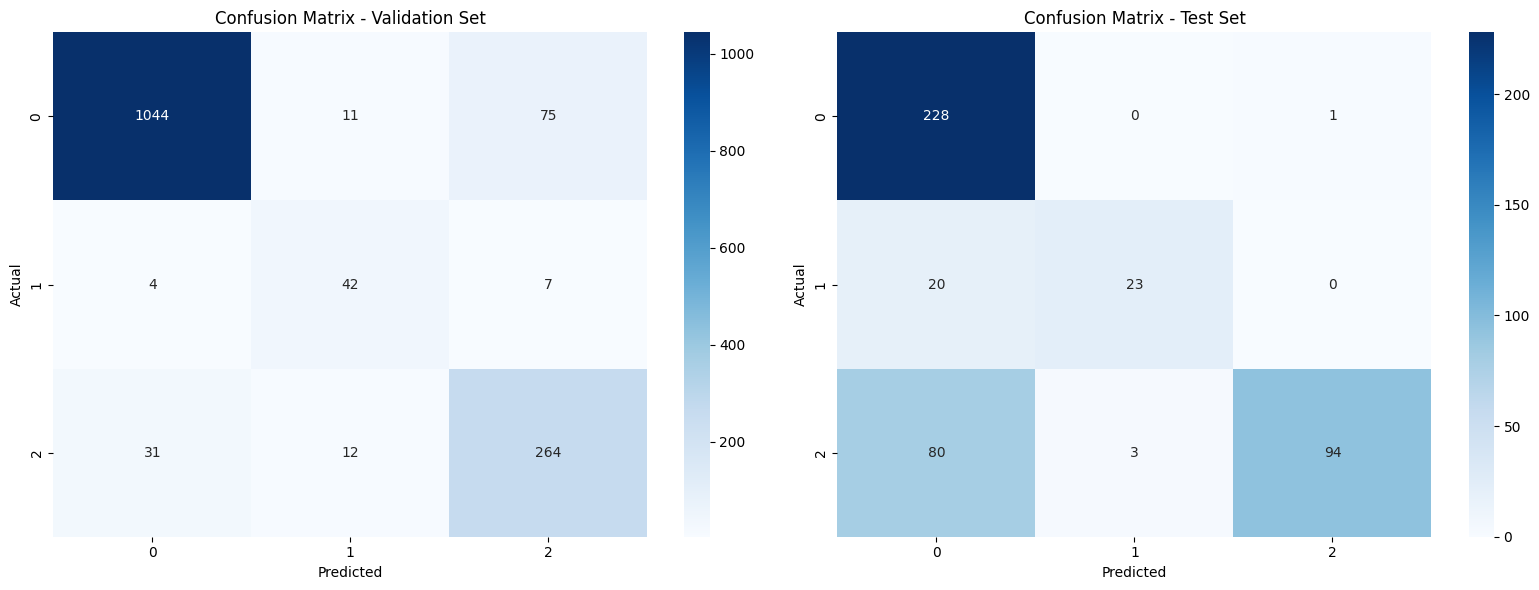

In [5]:
# Create confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test_labels, y_test_pred)

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot validation confusion matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Validation Set')

# Plot test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - Test Set')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Based on the confusion matrix, the model for both validation and test dataset performs well for certain classes. Across all the traffic class, it's able to predict accurately. Resulting in high True positives (TP) and true negatives (TN) while false positives (FP) and false negatives (FN) are low.

---

Plot a graph based on the base model classication metrics for better visualisation 

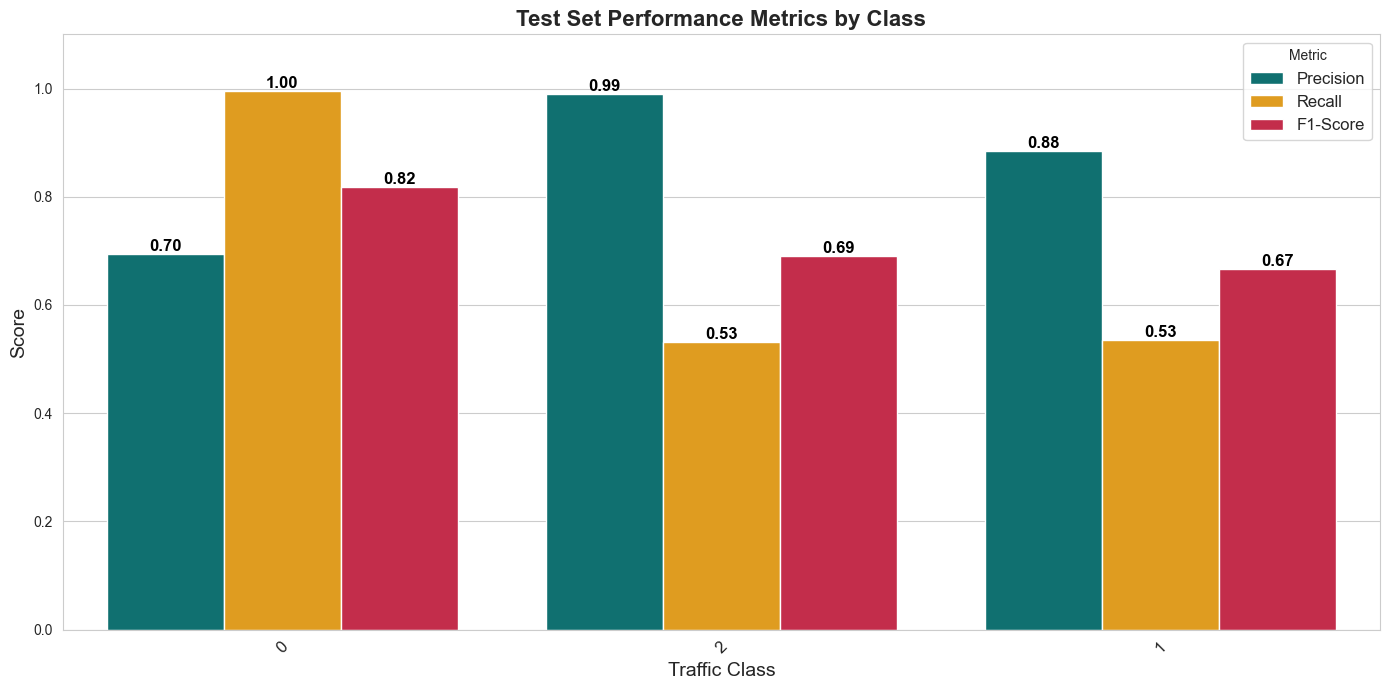

In [6]:
# Calculate metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_test_pred)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
 
# Sort by F1-Score (descending) for better visualization
metrics_df = metrics_df.sort_values(by="F1-Score", ascending=False)

# Melt for easier plotting
metrics_melt = pd.melt(metrics_df, id_vars=['Class'], 
                      value_vars=['Precision', 'Recall', 'F1-Score'],
                      var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")  # Add a clean grid style
palette = {"Precision": "teal", "Recall": "orange", "F1-Score": "crimson"}  # Custom colors

ax = sns.barplot(data=metrics_melt, x='Class', y='Score', hue='Metric', palette=palette)

# Add value labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with height > 0
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Titles and labels
plt.title('Test Set Performance Metrics by Class', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.1)  # Slightly above 1 for better spacing
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()

With the result classification performance of the model, this visualisation is done to provide readability and clarity with the goal of allowing quick identification on which traffic class the model perform well on and where improvements may be needed.

The graph is sorted by the F1-score, as a balancing of precision and recall is the focus. Based on the graph, improvements can be made on the recall on both class 0 and 2.

---

Generate a graph to determine the best K value for both validation and test dataset.

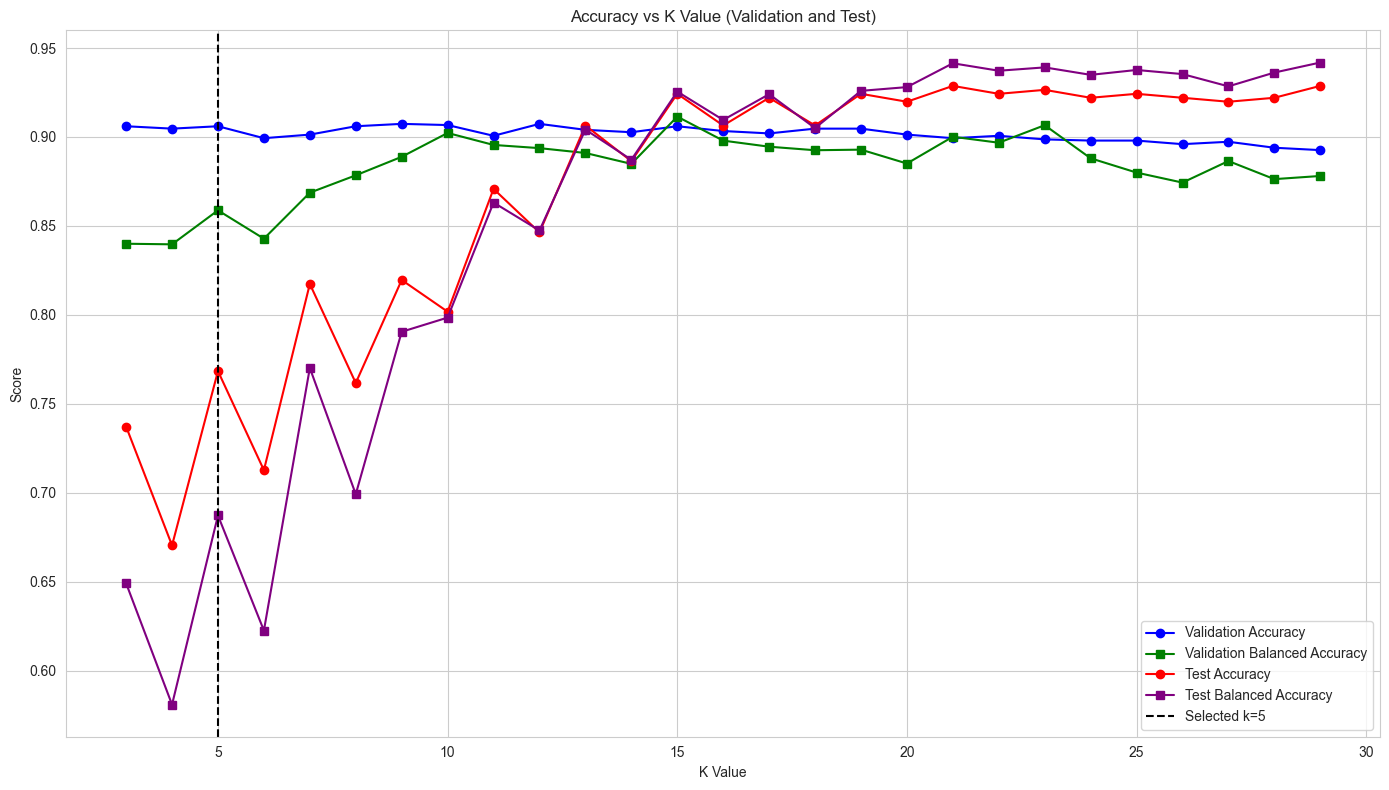

In [7]:
# Testing different K values for both validation and test sets
k_range = range(3, 30)
val_scores = []
val_balanced_scores = []
test_scores = []
test_balanced_scores = []

for k in k_range:
    knn_test = KNeighborsClassifier(n_neighbors=k)
    knn_test.fit(X_train_scaled, y_train)
    
    # Validation set predictions
    y_val_pred = knn_test.predict(X_val_scaled)
    val_scores.append(accuracy_score(y_val, y_val_pred))
    val_balanced_scores.append(balanced_accuracy_score(y_val, y_val_pred))
    
    # Test set predictions
    y_test_pred = knn_test.predict(X_test_scaled)
    test_scores.append(accuracy_score(y_test_labels, y_test_pred))
    test_balanced_scores.append(balanced_accuracy_score(y_test_labels, y_test_pred))

# Plot results
plt.figure(figsize=(14, 8))

# Plot validation set metrics
plt.plot(k_range, val_scores, 'o-', color='blue', label='Validation Accuracy')
plt.plot(k_range, val_balanced_scores, 's-', color='green', label='Validation Balanced Accuracy')

# Plot test set metrics
plt.plot(k_range, test_scores, 'o-', color='red', label='Test Accuracy')
plt.plot(k_range, test_balanced_scores, 's-', color='purple', label='Test Balanced Accuracy')

# Add vertical line for k=5
plt.axvline(x=5, color='black', linestyle='--', label='Selected k=5')

plt.xlabel('K Value')
plt.ylabel('Score')
plt.title('Accuracy vs K Value (Validation and Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This graph is used to analyse the different values of K (number of neighbours) affect the performance of KNN on both validation and test dataset. Providing a simple way to identify the optimal k value that provide the best accuracy. 

However, this is done using a single train-validation split. So the result would vary depending on how the data is split. Therefore, this isn't the most optimal way of finding the best parameter for KNN.

---

Multiple parameters for GridSearchCV
- n_neighbors: Used to determine the number of neighbours to consider making a data point
- weights: Used to determine the weighting function used
- p: Used to specify the power parameter used to calculate distance between data point
- metric: Define the distance metric to be used

In [8]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': range(3, 21),  # Test values from 3 to 20
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Distance metric
}

Initialize the KNN model and use GridSearchCV to search for the best parameters and calculate the best cross-validation accuracy.

In [9]:
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(
    estimator=knn, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

# Perform grid search on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the corresponding accuracy
print(f"Best parameters found: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

Best parameters found: {'metric': 'minkowski', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
Best cross-validation accuracy: 0.9085


After running through multiple combinations of the parameters in the param_grid. The best parameter is found with the cross-validation accuracy of 0.9085

This provide a better generalise model that performs well across different subsets of the data. The optimised configuration ensures that model works well with unseen data, leading to improved performance on both validation and test dataset.

---

Initialize the KNN model with the best parameter from GridSearchCV, then validate with training data. After validating with training data, validate the model performance with test data to check both the accuracy and balanced accuracy.

Generate a classification report with precision, recall, f1-score and support.

In [10]:
# Get the best model from GridSearchCV
best_knn = grid_search.best_estimator_

# Validate the best model on the validation set
y_val_pred = best_knn.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with Best Model: {val_accuracy:.4f}")
print(f"Validation Balanced Accuracy: {balanced_acc:.4f}")

# Display classification report for the validation set
unique_classes = np.unique(y_val)
target_names = [str(cls) for cls in unique_classes]  # Convert to string if necessary
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Test the best model on the test set
y_test_pred = best_knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy with Best Model: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

# Display classification report for the test set
print("\nTest Classification Report:")
print(classification_report(y_test_labels, y_test_pred, target_names=target_names))

Validation Accuracy with Best Model: 0.9188
Validation Balanced Accuracy: 0.8934

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1130
           1       0.68      0.85      0.76        53
           2       0.77      0.91      0.83       307

    accuracy                           0.92      1490
   macro avg       0.81      0.89      0.85      1490
weighted avg       0.93      0.92      0.92      1490

Test Accuracy with Best Model: 0.8374
Test Balanced Accuracy: 0.8110

Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       229
           1       0.89      0.79      0.84        43
           2       0.96      0.66      0.78       177

    accuracy                           0.84       449
   macro avg       0.88      0.81      0.83       449
weighted avg       0.86      0.84      0.83       449



Generate a confusion matrix to visualise the accuracy of classication.

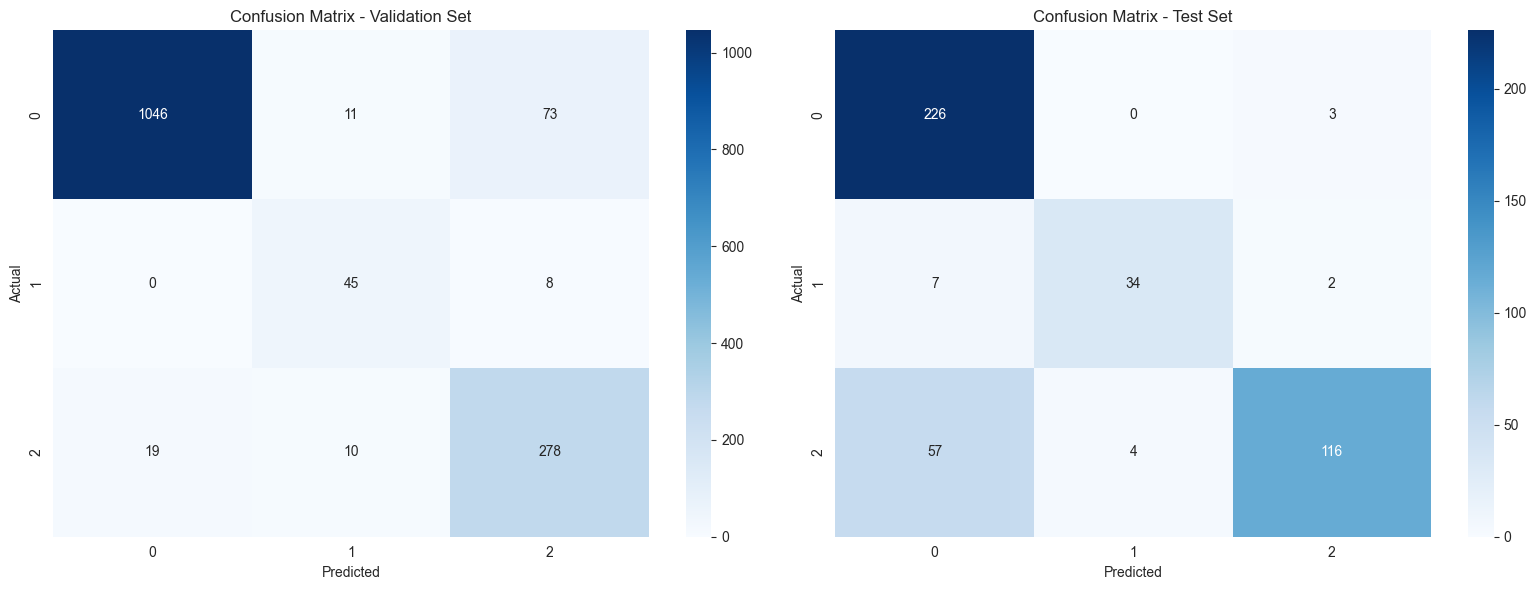

In [11]:
# Create confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test_labels, y_test_pred)

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot validation confusion matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Validation Set')

# Plot test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - Test Set')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Based on the confusion matrix, after fine-tuning the model there is an increase in both validation and test dataset performance. Resulting in a higher high True positives (TP) and true negatives (TN) while false positives (FP) and false negatives (FN) are lower.

---

Plot a graph based on the fine-tuned model classication metrics for better visualisation 

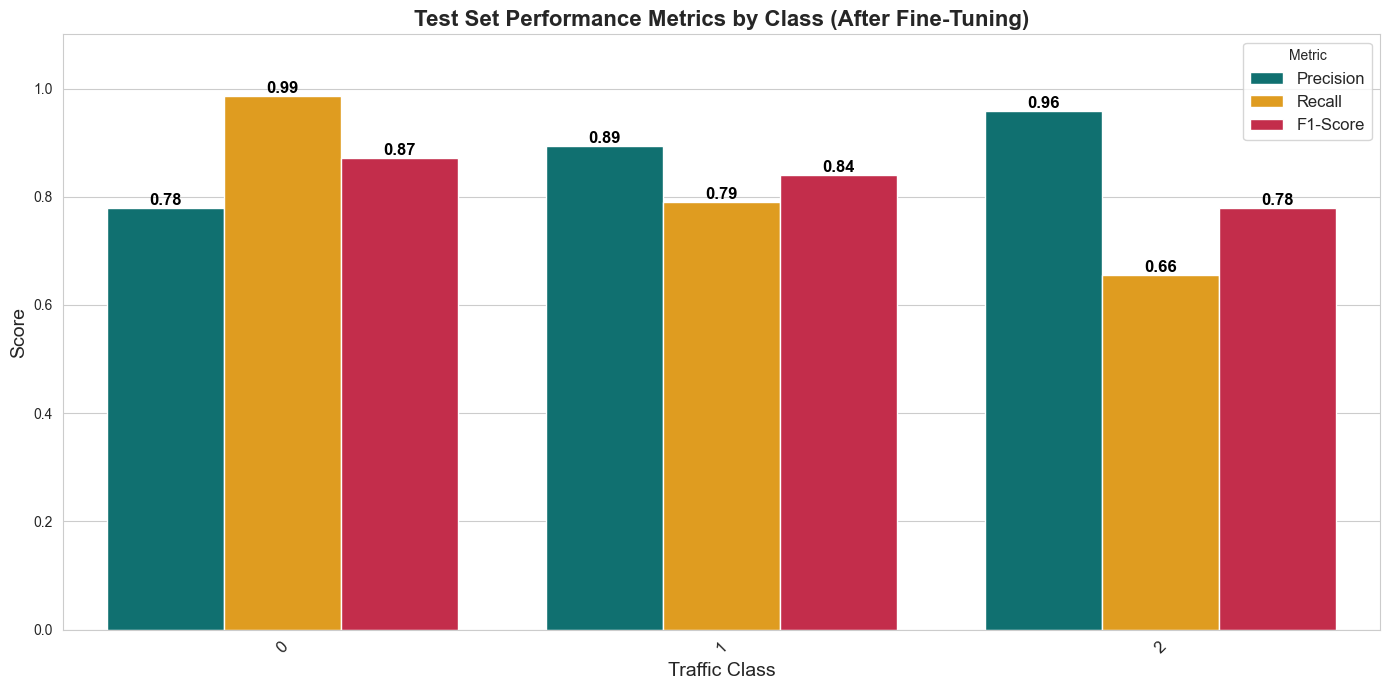

In [12]:
# Calculate metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_test_pred)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Sort by F1-Score (descending) for better visualization
metrics_df = metrics_df.sort_values(by="F1-Score", ascending=False)

# Melt for easier plotting
metrics_melt = pd.melt(metrics_df, id_vars=['Class'], 
                      value_vars=['Precision', 'Recall', 'F1-Score'],
                      var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")  # Add a clean grid style
palette = {"Precision": "teal", "Recall": "orange", "F1-Score": "crimson"}  # Custom colors

ax = sns.barplot(data=metrics_melt, x='Class', y='Score', hue='Metric', palette=palette)

# Add value labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with height > 0
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Titles and labels
plt.title('Test Set Performance Metrics by Class (After Fine-Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.1)  # Slightly above 1 for better spacing
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()


With the fine-tune model classification performance of the model, this visualisation is done to provide readability and clarity with the goal of allowing quick identification on which traffic class the model perform well on and where improvements may be needed.

The graph is sorted by the F1-score, as a balancing of precision and recall is the focus. Based on the graph, improvements are made on class 1 and 2 recall with an improvement from 0.53 to 0.79 for class 1 and 0.53 to 0.66 for class 2. Improvements across all classes F1-score, show that the model is performing better with the fine-tune parameters.

---

Visualise the importance of each features have to the model's predictions.

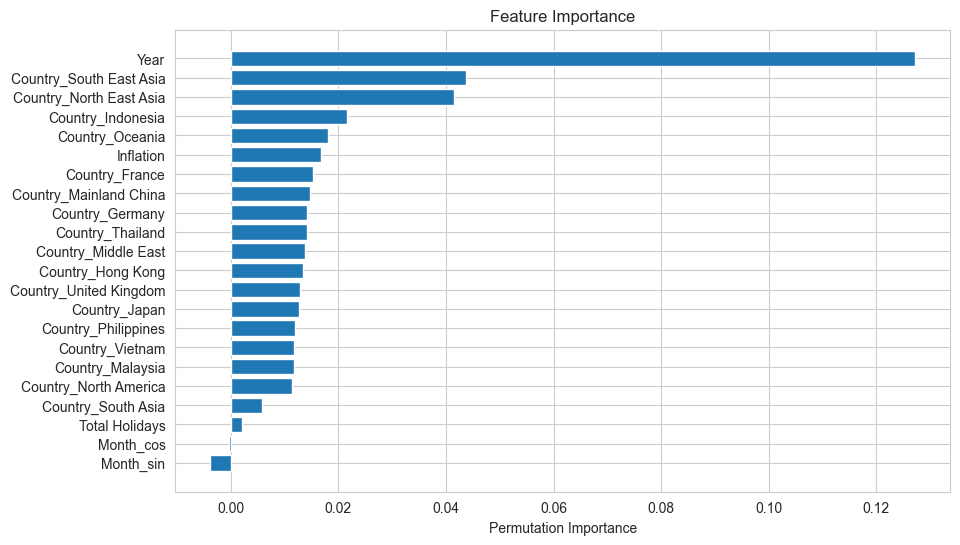

In [13]:
# Calculate permutation importance
result = permutation_importance(best_knn, X_val_scaled, y_val, n_repeats=10, random_state=42)

# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

The graph shows which features are the most important in the KNN model. It shows that 'Year', 'Country_South East Asia', 'Country_North East Asia' proves to be important for the model in making its predictions.

---

Generate a graph to visualise the effects of each hyperparameter on the model's accuracy

E:\Temp\ipykernel_17272\1414265433.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(['Manhattan (p=1)', 'Euclidean (p=2)'])


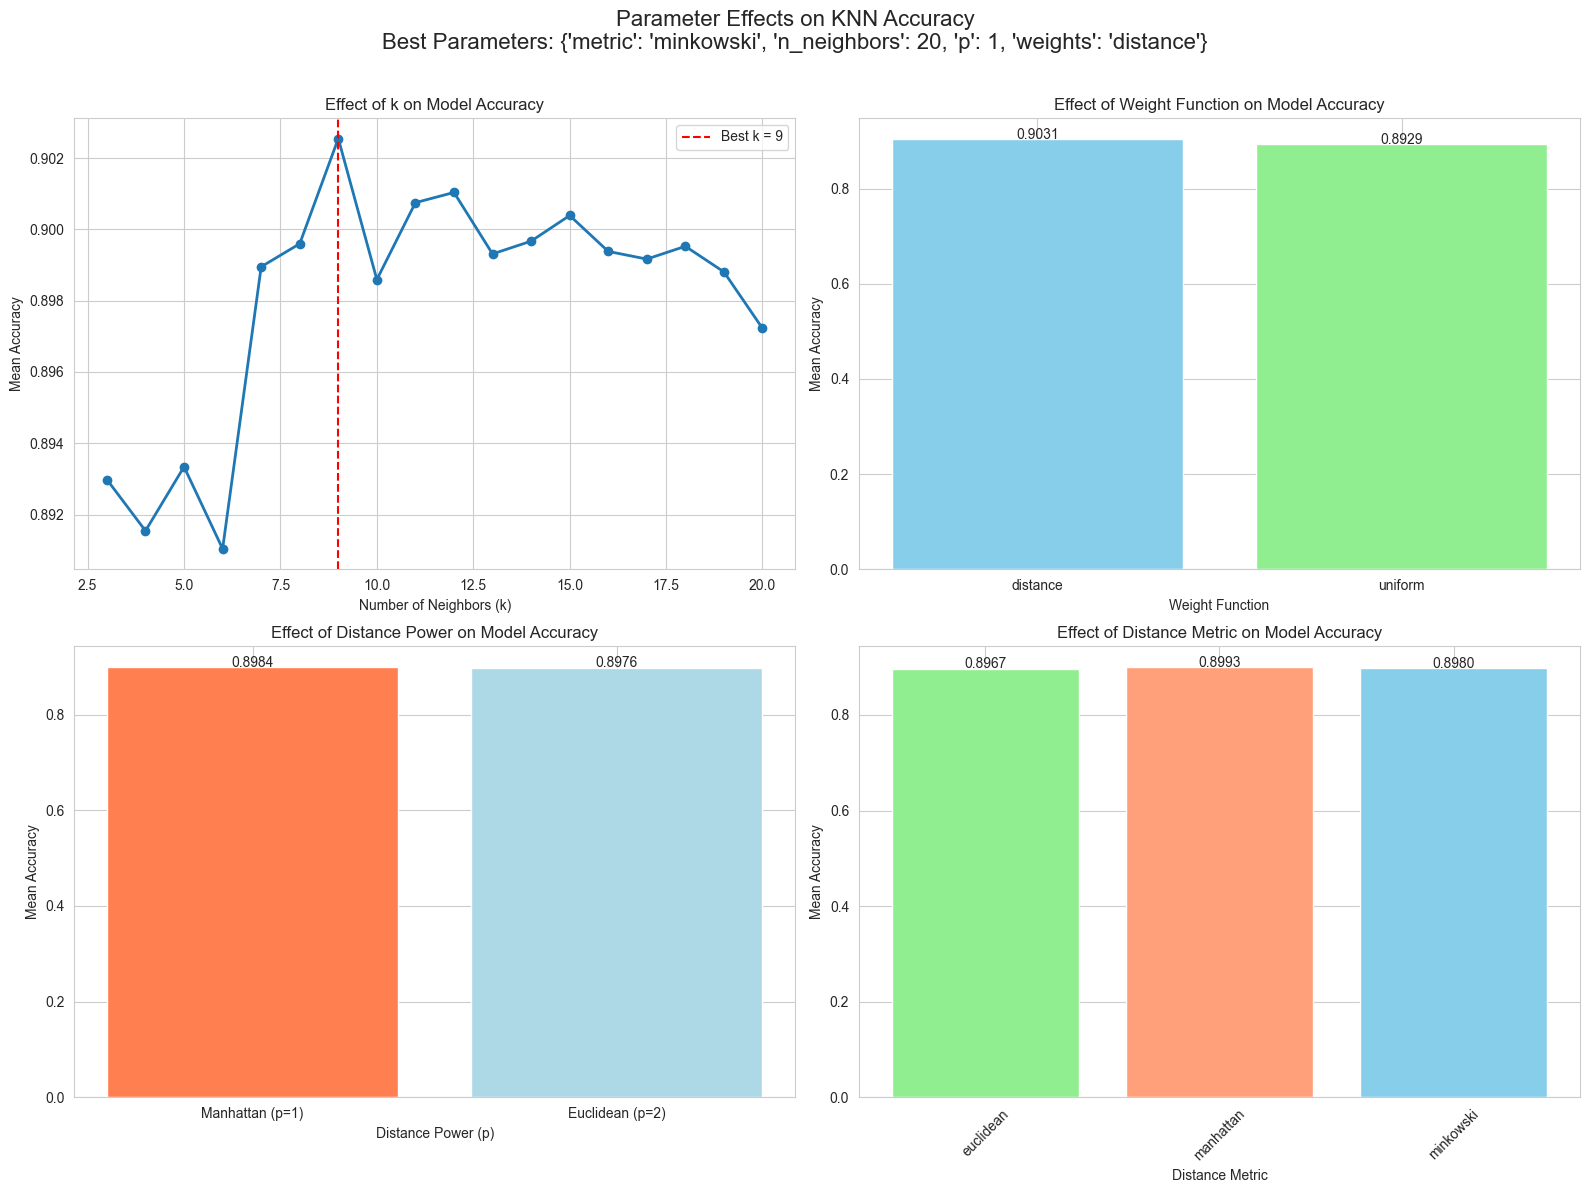

In [14]:
# Extract results from grid search
results = pd.DataFrame(grid_search.cv_results_)

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot for n_neighbors
n_neighbors_df = results.groupby('param_n_neighbors')['mean_test_score'].mean().reset_index()
axs[0, 0].plot(n_neighbors_df['param_n_neighbors'], n_neighbors_df['mean_test_score'], 'o-', linewidth=2)
axs[0, 0].set_xlabel('Number of Neighbors (k)')
axs[0, 0].set_ylabel('Mean Accuracy')
axs[0, 0].set_title('Effect of k on Model Accuracy')
axs[0, 0].grid(True)
best_k = n_neighbors_df.loc[n_neighbors_df['mean_test_score'].idxmax(), 'param_n_neighbors']
axs[0, 0].axvline(x=best_k, color='r', linestyle='--', 
                 label=f'Best k = {best_k}')
axs[0, 0].legend()

# Plot for weights
weights_df = results.groupby('param_weights')['mean_test_score'].mean().reset_index()
axs[0, 1].bar(weights_df['param_weights'], weights_df['mean_test_score'], color=['skyblue', 'lightgreen'])
axs[0, 1].set_xlabel('Weight Function')
axs[0, 1].set_ylabel('Mean Accuracy')
axs[0, 1].set_title('Effect of Weight Function on Model Accuracy')
for i, v in enumerate(weights_df['mean_test_score']):
    axs[0, 1].text(i, v + 0.001, f"{v:.4f}", ha='center')
axs[0, 1].grid(True, axis='y')

# Plot for p (Manhattan vs. Euclidean)
p_df = results.groupby('param_p')['mean_test_score'].mean().reset_index()
axs[1, 0].bar(p_df['param_p'].astype(str), p_df['mean_test_score'], color=['coral', 'lightblue'])
axs[1, 0].set_xlabel('Distance Power (p)')
axs[1, 0].set_ylabel('Mean Accuracy')
axs[1, 0].set_title('Effect of Distance Power on Model Accuracy')
axs[1, 0].set_xticklabels(['Manhattan (p=1)', 'Euclidean (p=2)'])
for i, v in enumerate(p_df['mean_test_score']):
    axs[1, 0].text(i, v + 0.001, f"{v:.4f}", ha='center')
axs[1, 0].grid(True, axis='y')

# Plot for metric
metric_df = results.groupby('param_metric')['mean_test_score'].mean().reset_index()
axs[1, 1].bar(metric_df['param_metric'], metric_df['mean_test_score'], color=['lightgreen', 'lightsalmon', 'skyblue'])
axs[1, 1].set_xlabel('Distance Metric')
axs[1, 1].set_ylabel('Mean Accuracy')
axs[1, 1].set_title('Effect of Distance Metric on Model Accuracy')
axs[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(metric_df['mean_test_score']):
    axs[1, 1].text(i, v + 0.001, f"{v:.4f}", ha='center')
axs[1, 1].grid(True, axis='y')

# Add a title for the entire figure
fig.suptitle(f'Parameter Effects on KNN Accuracy\nBest Parameters: {grid_search.best_params_}', 
            fontsize=16, y=0.99)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Based on this comprehensive graph, it shows how different hyperparameters influence the accuracy of the model. This shows the individual performance rather than the overall combination of all the parameters used to determine the model accuracy. Providing an insight on how each parameters can impact the model.

While individual parameters such as the K neighbours shows that '7' proves to have the highest accuracy. Only after combining with other parameters, ensures that the model is able to acheive its highest accuracy. As GridSearchCV ensures that the model is robust and adaptable to various datasets.